# xgboost on Mushroom Dataset

## 导入工具包

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Reading the file

Kaggle竞赛蘑菇数据集，22维特征
https://www.kaggle.com/uciml/mushroom-classification

调用head函数看看每个特征的基本情况

In [2]:
# path to where the data lies
dpath = '../data/'
data = pd.read_csv(dpath+"mushrooms.csv")
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
# 看看数据是否有空值／缺失数据
data.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

很幸运，该数据没有空值／缺失数据

### 看看是否为一个两类分类问题（poisonous，edibl）

In [4]:
data['class'].unique()

array(['p', 'e'], dtype=object)

In [5]:
#数据基本信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

In [6]:
#观察一下数据规模
data.shape

(8124, 23)

### 特征编码

特征全是类别型变量，很多模型需要数值型的输入（Logisstic回归、xgboost...)

In [7]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in data.columns:
    data[col] = labelencoder.fit_transform(data[col].astype(str))

#data.head()

In [8]:
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


LableEncoder是不合适的，因为是有序的。而颜色等特征是没有序关系。决策树等模型不care，但logistic回归不行。后面我们再试试OneHotEncoder

In [9]:
#X = data.iloc[:,1:23]  # all rows, all the features and no labels
#y = data.iloc[:, 0]  # all rows, label only

y = data['class']    #用列名访问更直观
X = data.drop('class', axis = 1)

### 数据集是一个文件，我们自己分出一部分来做测试吧（不是校验集）

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [11]:
columns = X_train.columns

In [12]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

/usr/local/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


## Default XGBoost

In [13]:
from xgboost import XGBClassifier
model_XGB=XGBClassifier()

In [14]:
model_XGB.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [15]:
y_prob = model_XGB.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model_XGB.score(X_test, y_pred)

1.0

In [16]:
auc_roc=roc_auc_score(y_test,y_pred)
auc_roc

1.0

### 特征重要性
在XGBoost中特征重要性已经自动算好，存放在feature_importances_

In [17]:
  print(model_XGB.feature_importances_)

[0.00200508 0.00301184 0.01164484 0.0050957  0.06542522 0.
 0.01254669 0.09593841 0.4388894  0.031197   0.02373331 0.01908208
 0.01817624 0.04222912 0.00920601 0.         0.         0.00674974
 0.         0.08038267 0.12050713 0.01417955]


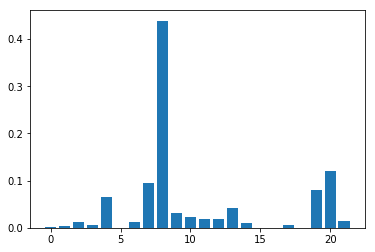

In [18]:
# plot
from matplotlib import pyplot
pyplot.bar(range(len(model_XGB.feature_importances_)), model_XGB.feature_importances_)
pyplot.show()

上述表是按特征顺序打印，还可以使用XGBoost内嵌的函数，按特征重要性排序

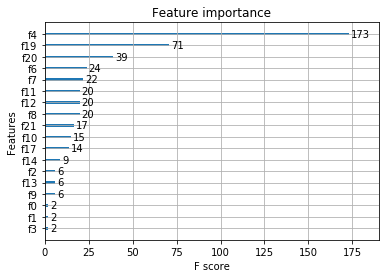

In [19]:
# plot feature importance using built-in function
from xgboost import plot_importance
plot_importance(model_XGB)
pyplot.show()

可以根据特征重要性进行特征选择

In [20]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# Fit model using each importance as a threshold
thresholds = sort(model_XGB.feature_importances_)
for thresh in thresholds:
  # select features using threshold
  selection = SelectFromModel(model_XGB, threshold=thresh, prefit=True)
  select_X_train = selection.transform(X_train)
  # train model
  selection_model = XGBClassifier()
  selection_model.fit(select_X_train, y_train)
# eval model
  select_X_test = selection.transform(X_test)
  y_pred = selection_model.predict(select_X_test)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test, predictions)
  print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1],
      accuracy*100.0))

Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.000, n=22, Accuracy: 100.00%
Thresh=0.002, n=18, Accuracy: 100.00%
Thresh=0.003, n=17, Accuracy: 100.00%
Thresh=0.005, n=16, Accuracy: 100.00%
Thresh=0.007, n=15, Accuracy: 100.00%
Thresh=0.009, n=14, Accuracy: 100.00%
Thresh=0.012, n=13, Accuracy: 100.00%
Thresh=0.013, n=12, Accuracy: 100.00%
Thresh=0.014, n=11, Accuracy: 100.00%
Thresh=0.018, n=10, Accuracy: 100.00%
Thresh=0.019, n=9, Accuracy: 100.00%
Thresh=0.024, n=8, Accuracy: 100.00%
Thresh=0.031, n=7, Accuracy: 99.57%
Thresh=0.042, n=6, Accuracy: 99.57%
Thresh=0.065, n=5, Accuracy: 99.57%
Thresh=0.080, n=4, Accuracy: 98.34%
Thresh=0.096, n=3, Accuracy: 88.55%
Thresh=0.121, n=2, Accuracy: 85.60%
Thresh=0.439, n=1, Accuracy: 80.98%
